# Classification Experiment: Combining Classifiers
---
This Notebook, includes a series of experiments, on using a node's Social Information for classification.

Libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import json
import tweepy
import time

from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import joblib
import time 

import seaborn as sns

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score

Twitter API Authentication:

In [2]:
twitter_credentials = []
with open('../../../../twitter_credentials.json', 'r') as f:
    twitter_credentials = json.load(f)

auth = tweepy.OAuthHandler(twitter_credentials['consumer_key'], twitter_credentials['consumer_secret'])
auth.set_access_token(twitter_credentials['access_token_key'],twitter_credentials['access_token_secret'])
API = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, timeout=60*5)

In [3]:
# Function For Text Normalization
def clean_text(data):
    urls = r'http\S+'
    non_unicode_char = r'\W'
    numbers = r'[0-9_]'
    fix_whitespace = r'\s+'
    single_whitespace = ' '
    
    data = (data.replace([urls], single_whitespace, regex=True)
                    .replace([non_unicode_char, numbers], single_whitespace, regex=True)
                    .replace(fix_whitespace, single_whitespace, regex=True))
    data = data.apply(lambda s: s.lower() if type(s) == str else s)
    return data

nlp_el = spacy.load('el_core_news_md')
nlp_en = spacy.load('en_core_web_sm')
STOPWORDS = set(list(spacy.lang.en.STOP_WORDS) + list(spacy.lang.el.STOP_WORDS))

def remove_stopwords(row):
    row = [str(token) for token in nlp_el(row)]
    return [w for w in row if w not in STOPWORDS]

def tokenize_lemmatize(row):
    return [str(token.lemma_) for token in nlp_el(row)]

def tokenize_lemmatize_en(row):
    return [str(token.lemma_) for token in nlp_el(row)]

# Dataset
---

In [4]:
training_set = pd.read_csv('../../../../datasets/Hotels/classification/hotels-training-set-enhanced.csv')
training_set = training_set.replace(np.nan, '')

validation_set = pd.read_csv('../../../../datasets/Hotels/classification/hotels-validation-set-enhanced.csv')
validation_set = validation_set.replace(np.nan, '')

# Classifiers

## Name Description

In [5]:
def get_text_data_hotel_nd(df):
    df['textdata'] = clean_text(df['name'] + ' ' + df['description'])
    df['textdata'] = df['textdata'].apply(lambda row: tokenize_lemmatize(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    df['textdata'] = df['textdata'].apply(lambda row: tokenize_lemmatize_en(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    df['textdata'] = df['textdata'].apply(lambda row: remove_stopwords(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    
    return df.textdata


get_text = FunctionTransformer(get_text_data_hotel_nd)

pipeline_nd = Pipeline([
    ('selector', get_text),
    ('tfidf', TfidfVectorizer(max_df=0.5, max_features=1000, min_df=1)),
    ('svm', svm.SVC(kernel='rbf', C=1, probability=True))
])

## Statuses

In [6]:
def get_text_data_hotel_t(df):
    df['textdata'] = clean_text(df['recent_100_statuses'])
    df['textdata'] = df['textdata'].apply(lambda row: tokenize_lemmatize(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    df['textdata'] = df['textdata'].apply(lambda row: tokenize_lemmatize_en(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    df['textdata'] = df['textdata'].apply(lambda row: remove_stopwords(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    
    return df.textdata


get_text_t = FunctionTransformer(get_text_data_hotel_t)

pipeline_t = Pipeline([
    ('selector_t', get_text_t),
    ('tfidf', TfidfVectorizer(max_df=0.75, max_features=None, min_df=5)),
    ('svm', svm.SVC(kernel='rbf', C=1, probability=True))
])

## Friends

In [7]:
# Function to select the data
def get_data_hotel_fr(df):
    data = df['friends_hotel_count_1000'].to_numpy()
    return data.reshape(-1,1)


get_data = FunctionTransformer(get_data_hotel_fr)

# The pipeline
pipeline_fr = Pipeline([
    ('selector', get_data),
    ('svm', svm.SVC(C=0.1, kernel='sigmoid', probability=True))
])


## Followers

In [8]:
# Function to select the data
def get_data_hotel_fo(df):
    data = df['followers_hotel_count_1000'].to_numpy()
    return data.reshape(-1,1)


get_data_fo = FunctionTransformer(get_data_hotel_fo)

# The pipeline
pipeline_fo = Pipeline([
    ('selector', get_data_fo),
    ('svm', svm.SVC(C=0.1, kernel='linear', probability=True))
])


In [9]:
predictions = pd.DataFrame()
predictions['screen_name'] = validation_set['screen_name']
predictions['true_label'] = validation_set['hotel']

# Voting Classifier "Soft"

In [10]:
target_names = ['Not-Hotel', 'Hotel']

Fitting 5 folds for each of 7 candidates, totalling 35 fits
 Best Params: {'voting__weights': [1, 1, 0.1, 0.1]}.
 Score: 0.9199999999999999
              precision    recall  f1-score   support

   Not-Hotel       0.93      1.00      0.96        25
       Hotel       1.00      0.92      0.96        25

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



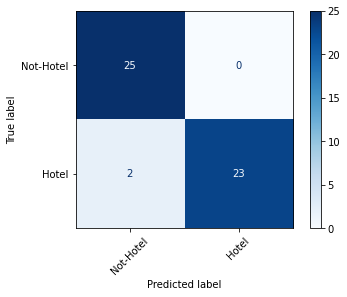

In [13]:
clf = VotingClassifier(estimators=[('nd', pipeline_nd), 
                                   ('t', pipeline_t), 
                                   ('fr', pipeline_fr), 
                                   ('fo', pipeline_fo)], 
                       voting='soft'
                      )

pipe = Pipeline([('voting', clf)])


parameters = {'voting__weights':[[10, 10, 5, 5],
                                 [5, 3, 1, 1],
                                 [2, 1, 0.1, 0.1],
                                 [1, 1, 0.1, 0.1],
                                 [1,1,1,1],
                                 [5,3,0.1,0.1],
                                 [3,5,0.1,0.1]]}

grid = GridSearchCV(pipe, parameters, n_jobs = 4, verbose=1)
grid.fit(training_set, training_set.hotel)

print(f' Best Params: {grid.best_params_}.\n Score: {grid.best_score_}')


plot_confusion_matrix(grid.best_estimator_, 
                      validation_set, 
                      validation_set.hotel, 
                      display_labels=target_names, 
                      xticks_rotation=45, 
                      cmap=plt.cm.Blues)

y_pred=grid.best_estimator_.predict(validation_set)

print(classification_report(y_true = validation_set.hotel, 
                            y_pred=y_pred, 
                            target_names=target_names))


predictions['voting_soft_weights'] = y_pred

## Varying Weights

In [14]:
pipeline_nd.fit(training_set, training_set.hotel)
nd_proba = pipeline_nd.predict_proba(validation_set).round(4)

In [15]:
pipeline_t.fit(training_set, training_set.hotel)
tme_proba = pipeline_t.predict_proba(validation_set).round(4)

In [16]:
pipeline_fr.fit(training_set, training_set.hotel)
fr_proba = pipeline_fr.predict_proba(validation_set).round(4)

In [17]:
pipeline_fo.fit(training_set, training_set.hotel)
fo_proba = pipeline_fo.predict_proba(validation_set).round(4)

In [18]:
print(nd_proba.min(), nd_proba.max())
print(tme_proba.min(), tme_proba.max())
print(fr_proba.min(), fr_proba.max())
print(fo_proba.min(), fo_proba.max())

0.0 1.0
0.0255 0.9745
0.2402 0.7598
0.0297 0.9703


In [19]:
a = [1 for i in range(len(validation_set))]
b = [1 for i in range(len(validation_set))]
c = [0.5 for i in range(len(validation_set))]
d = [0.5 for i in range(len(validation_set))]

for i, description in enumerate(validation_set['description']):
    if description == '':
        a[i] = 0.5
    if validation_set.iloc[i]['statuses_count'] == 0:
        b[i] = 0
    if validation_set.iloc[i]['friends_count'] == 0:
        c[i] = 0
    if validation_set.iloc[i]['followers_count'] == 0:
        d[i] = 0
        

In [20]:
proba = [0 for i in range(len(validation_set))]
for i in range(len(validation_set)):
    proba[i] = (a[i]*nd_proba[i] + b[i]*tme_proba[i] + c[i]*fr_proba[i] + d[i]*fo_proba[i]) / (a[i]+b[i]+c[i]+d[i])


    
print(classification_report(y_true = validation_set.hotel, 
                            y_pred=np.argmax(proba, axis=1), 
                            target_names=target_names))

              precision    recall  f1-score   support

   Not-Hotel       0.93      1.00      0.96        25
       Hotel       1.00      0.92      0.96        25

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



[Text(0.5, 0, 'Not-Hotel'), Text(1.5, 0, 'Hotel')]

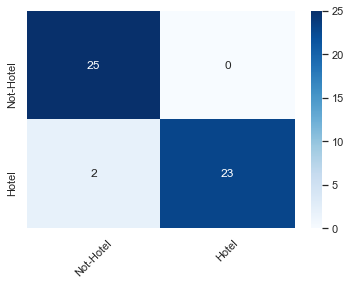

In [21]:
df_cm = pd.DataFrame(confusion_matrix(y_true = validation_set.hotel, 
                            y_pred=np.argmax(proba, axis=1)), range(2), range(2))
#plt.figure(figsize=(10,7))
sns.set(font_scale=1) # for label size
mtrx = sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},
           cmap=plt.cm.Blues,
           xticklabels=target_names, 
            yticklabels=target_names) # font size

loc, labels = plt.xticks()
mtrx.set_xticklabels(labels, rotation=45)

In [22]:
y_pred=np.argmax(proba, axis=1)
predictions['y_pred'] = y_pred

In [23]:
predictions[predictions['true_label'] != predictions['y_pred']]

,screen_name,true_label,voting_soft_weights,y_pred
13,alikescamping,1,0,0
32,MedRoyalHotel,1,0,0


In [24]:
validation_set.iloc[13]

screen_name                   alikescamping
name                                      a
description                                
statuses_count                            0
friends_count                            11
followers_count                          27
recent_100_statuses                        
hotel                                     1
friends_hotel_count_1000                  1
followers_hotel_count_1000                3
mention_hotel_count                       0
textdata                                   
Name: 13, dtype: object